# AthNLP 2025 - Lab 5: Prompting


## Install dependencies

In [ ]:
!pip install -q -U datasets
!pip install -q python-liquid
!pip install -q bitsandbytes

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 136.3/136.3 kB 13.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.9/72.9 MB 35.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 121.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 95.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 53.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 44.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 20.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 105.5 MB/s eta 0:00:00


## Data and model preparation

### Load the dataset

The GSM8K dataset (short for Grade School Math 8K) is a high-quality benchmark dataset designed to evaluate the mathematical reasoning capabilities of language models. It was introduced by OpenAI in the paper [Training Verifiers to Solve Math Word Problems](https://arxiv.org/abs/2110.14168) and contains 8,500 high-quality, human-annotated grade school-level math word problems.

Each problem includes:
*   a **question** (math problem written in natural language)
*   a **step-by-step rationale** (the solution written in full English prose)
*   a **final answer** (number)

The rationales (explanations) are separated from final answers using "\n####".

In [ ]:
from datasets import load_dataset

math_data = load_dataset("openai/gsm8k", "main")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

main/train-00000-of-00001.parquet:   0%|          | 0.00/2.31M [00:00<?, ?B/s]

main/test-00000-of-00001.parquet:   0%|          | 0.00/419k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/7473 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1319 [00:00<?, ? examples/s]

We can look for example at how the question and answer are structured for item 5:

In [ ]:
['QUESTION: ' + math_data['test']['question'][5], 'ANSWER: ' + math_data['test']['answer'][5]]

['QUESTION: Kylar went to the store to buy glasses for his new apartment. One glass costs $5, but every second glass costs only 60% of the price. Kylar wants to buy 16 glasses. How much does he need to pay for them?',
 'ANSWER: The discount price of one glass is 60/100 * 5 = $<<60/100*5=3>>3.\nIf every second glass is cheaper, that means Kylar is going to buy 16 / 2 = <<16/2=8>>8 cheaper glasses.\nSo for the cheaper glasses, Kylar is going to pay 8 * 3 = $<<8*3=24>>24.\nAnd for the regular-priced glasses, Kylar will pay 8 * 5 = $<<8*5=40>>40.\nSo in total Kylar needs to pay 24 + 40 = $<<24+40=64>>64 for the glasses he wants to buy.\n#### 64']

Let's gather all question-answer pairs in a list for easier manipulation.

In [ ]:
contexts = [[math_data['test']['question'][i], math_data['test']['answer'][i]]
            for i in range(len(math_data['test']['question']))]

### Load the model

Loading models from the Hugging Face Hub typically involves using the 🤗 [Transformers library](https://huggingface.co/docs/transformers/en/index), which allows easy access to pre-trained models for tasks like text classification, translation, summarization, and more. You typically need two components:
*   the **model** (e.g., Meta-Llama-3.1, mistral-7b-instruct, gemma-2-27b; check more examples below)
*   the **tokenizer** (for preprocessing text; check [Lab 0](https://github.com/athnlp/athnlp-labs-2025) for more information)

In [ ]:
import torch

device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

# 4bit pre quantized models that are supported for 4x faster downloading + no OOMs.
fourbit_models = [
    "unsloth/Meta-Llama-3.1-8B-bnb-4bit",      # Llama-3.1 2x faster
    "unsloth/Meta-Llama-3.1-8B-Instruct-bnb-4bit",
    "unsloth/Meta-Llama-3.1-70B-bnb-4bit",
    "unsloth/Meta-Llama-3.1-405B-bnb-4bit",    # 4bit for 405b!
    "unsloth/Mistral-Small-Instruct-2409",     # Mistral 22b 2x faster!
    "unsloth/mistral-7b-instruct-v0.3-bnb-4bit",
    "unsloth/Phi-3.5-mini-instruct",           # Phi-3.5 2x faster!
    "unsloth/Phi-3-medium-4k-instruct",
    "unsloth/gemma-2-9b-bnb-4bit",
    "unsloth/gemma-2-27b-bnb-4bit",            # Gemma 2x faster!

    "unsloth/Llama-3.2-1B-bnb-4bit",           # NEW! Llama 3.2 models
    "unsloth/Llama-3.2-1B-Instruct-bnb-4bit",
    "unsloth/Llama-3.2-3B-bnb-4bit",
    "unsloth/Llama-3.2-3B-Instruct-bnb-4bit",

    "unsloth/Llama-3.3-70B-Instruct-bnb-4bit" # NEW! Llama 3.3 70B!
] # More models at https://huggingface.co/unsloth

import transformers
from transformers import AutoTokenizer, AutoModel, AutoModelForCausalLM

tokenizer = AutoTokenizer.from_pretrained(fourbit_models[1])

model = AutoModelForCausalLM.from_pretrained(
    fourbit_models[1],        # Meta-Llama-3.1-8B-Instruct-bnb-4bit
    device_map=device,
)

tokenizer_config.json: 0.00B [00:00, ?B/s]

tokenizer.json:   0%|          | 0.00/17.2M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/454 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/5.70G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

We can create a Hugging Face **text generation pipeline** for faster inference. Pipelines are simple and optimized inference class for many machine learning tasks like text generation, image segmentation, automatic speech recognition, document question answering, and more. You can find tutorials about pipelines [here](https://huggingface.co/docs/transformers/en/pipeline_tutorial).

In [ ]:
gen_pipeline = transformers.pipeline(
    "text-generation",
    model=model,
    tokenizer=tokenizer,
    device_map=device,
)

Device set to use cuda:0


Let's define a function to generate an answer. An important concept introduced at this stage is the incorporation of Padding ([PAD]), Beginning of Sequence ([BOS]), and End of Sequence ([EOS]) tokens, which are fundamental in structuring the model’s interpretation and generation of text sequences. Each of these tokens is typically assigned a unique identifier within the model's vocabulary (e.g., 0 or another reserved index, which is obtained by ...).

*   **PAD Token:** A pad token (short for padding token) is a special token used to ensure that all sequences within a batch have uniform length. Neural networks require input sequences of consistent length. However, textual data encountered in real-world scenarios often varies in length. To accommodate this, shorter sequences are extended by appending a designated padding token—commonly represented as [PAD]—so that they align with the length of the longest sequence in the batch.
*   **EOS Token:** As the model continues generating text, the process concludes upon the generation of an EOS token. This token marks the end of the current sequence, acting as a signal for the model to cease further output.
*   **BOS Token:** The BOS token is used to initiate the text generation process. It signifies the commencement of a new sequence, effectively triggering the model to begin producing text. This token functions similarly to a starting signal, indicating that the model should proceed with generation.


The use of [PAD], [BOS], and [EOS] tokens is critical not only for delineating the boundaries of text sequences but also for guiding the model in producing coherent and contextually appropriate outputs.

In [ ]:
def answer(question, num_beams=1):
    response = gen_pipeline(
        question,
        do_sample=True,
        temperature=0.6,
        num_beams=num_beams,
        max_new_tokens = 1500,
        eos_token_id=[tokenizer.eos_token_id, tokenizer.convert_tokens_to_ids("<|eot_id|>")],
        pad_token_id=tokenizer.eos_token_id,
        truncation=True,
        stopping_criteria=None
    )

    return response[0]['generated_text']

## Zero-shot inference without chain-of-thought thinking

### Create a prompt template

**Writing Effective Prompts:** The system prompt gives instructions to the LLM. Then a question will be passed to the prompt using the system template.
Prompts are the most basic mechanic of LLMs — you’ll be able to explore any idea that you can imagine, just by describing it with a few simple words. A prompt is a short text phrase that the LLM interprets to answer. Your prompt can have significant impact on your outcomes, so we’ll spend a bit of time here learning the fundamentals of how to write a good one.

As a general rule, an effective prompt should roughly follow the structure of the following:
> a [medium] of [subject], in the style of [style reference] [perspective], [emphasis], [modifiers]

See more tips about writing effective prompts [here](https://docs.alpacaml.com/guides/prompting).

In [ ]:
from liquid import Template

system_prompt = '''You are a helpful math expert, and your task is to answer a math question. Please answer directly and provide only the result (numerical answer). The result must be an integer.'''  # @param {type: "string"}

system_template = Template('''
Here is the question:
{{question}}
''')

We can now look at how the prompt is structured for item 5 before asking the model to provide an answer... We can observe the following:
*   **instruction:** str, describes the task the model should perform (system prompt).
*   **question:** str, context or input for the task. For example, when the instruction is "Summarize the following article", the input is the article.
*   **answer:** str, the answer to the instruction we have included in contexts.

In [ ]:
context = contexts[5]

def generate_prompt(context):
  prompt_llm = system_template.render(question=context[0])
  messages = [
      {"role": "system", "content": system_prompt},
      {"role": "user", "content": prompt_llm}
  ]
  prompt_final = tokenizer.apply_chat_template(messages, tokenize=False,
                                               add_generation_prompt=True)

  return prompt_final

print(generate_prompt(context))

<|begin_of_text|><|start_header_id|>system<|end_header_id|>

Cutting Knowledge Date: December 2023
Today Date: 26 Jul 2024

You are a helpful math expert, and your task is to answer a math question. Please answer directly and provide only the result (numerical answer). The result must be an integer.<|eot_id|><|start_header_id|>user<|end_header_id|>

Here is the question:
Kylar went to the store to buy glasses for his new apartment. One glass costs $5, but every second glass costs only 60% of the price. Kylar wants to buy 16 glasses. How much does he need to pay for them?<|eot_id|><|start_header_id|>assistant<|end_header_id|>




Let's ask the LLM to answer some questions and observe the answers:

In [ ]:
NUM_TEST_EXAMPLES = 10 # @param {type: "string"}
NUM_TEST_EXAMPLES = int(NUM_TEST_EXAMPLES)

In [ ]:
import re
from tqdm import tqdm

answers = []
for context in tqdm(contexts[0:NUM_TEST_EXAMPLES]):
    prompt_final = generate_prompt(context)

    ans = answer(prompt_final)
    answers.append(re.sub("\s+", " ", ans))

print("\n".join(answers))

100%|██████████| 10/10 [00:36<00:00,  3.61s/it]

<|begin_of_text|><|start_header_id|>system<|end_header_id|> Cutting Knowledge Date: December 2023 Today Date: 26 Jul 2024 You are a helpful math expert, and your task is to answer a math question. Please answer directly and provide only the result (numerical answer). The result must be an integer.<|eot_id|><|start_header_id|>user<|end_header_id|> Here is the question: Janet’s ducks lay 16 eggs per day. She eats three for breakfast every morning and bakes muffins for her friends every day with four. She sells the remainder at the farmers' market daily for $2 per fresh duck egg. How much in dollars does she make every day at the farmers' market?<|eot_id|><|start_header_id|>assistant<|end_header_id|> 16 - 3 - 4 = 13. 13 * 2 = 26
<|begin_of_text|><|start_header_id|>system<|end_header_id|> Cutting Knowledge Date: December 2023 Today Date: 26 Jul 2024 You are a helpful math expert, and your task is to answer a math question. Please answer directly and provide only the result (numerical answe

We can evaluate the model by computing accuracy. We have requested the model to provide a result (numerical answer) so we will search for the last integer in its generated answers and store it as the answer. Then we will compute how many times that is equal to the correct answer, which is separated from the reasoning behind it by "\n####", as we've already seen.

In [ ]:
def find_last_integer(s):
    # Find all integer-like patterns (including negative numbers)
    numbers = re.findall(r'-?\d+', s)

    if numbers:
        # Return the last one as an integer
        return int(numbers[-1])

    # Return None if no integer is found
    return None

def evaluate_accuracy(data, llm_answers):
  accuracy = 0.0
  for i in range(len(data)):
    correct_answer = int(data[i][1].split("\n####")[1].strip())
    llm_answer = find_last_integer(llm_answers[i])
    if correct_answer == llm_answer:
      accuracy += 1/len(data)
  return accuracy

llama_accuracy = evaluate_accuracy(contexts[0:NUM_TEST_EXAMPLES], answers)
print("LlaMA 3.1 0-shot performance (in terms of accuracy):", llama_accuracy)

LlaMA 3.1 0-shot performance (in terms of accuracy): 0.1


**Pause and reflect:** How can we improve the system performance?

* Try to enter different input texts in the `system_prompt` field and see what it gets to produce. What happens when you prompt the model to answer directly v.s. pause and reflect (like you right now 🙂).

* Try the proposed prompt below, where we ask the model to think step-by-step (this is called chain-of-thought thinking), adding specific instructions about generating a response (to make evaluation easier).

## Zero-shot inference with chain-of-thought thinking

### Create a prompt template

As mentioned earlier, the system prompt gives instructions to the LLM, which describes the task the model should perform (system prompt). We now ask the LLM to **think step-by-step** before giving an answer. Asking large language models to think step by step is important because it **improves the accuracy, reasoning, and interpretability** of their responses. Research shows that prompting LLMs to think step by step significantly improves their performance on tasks like math word problems (e.g., GSM8K, see [here](https://arxiv.org/pdf/2205.11916)). This is sometimes referred to as **chain-of-thought prompting**. In short, prompting LLMs to think step by step aligns with both better performance and greater clarity—especially when dealing with tasks that require **careful thought or multi-step logic**.

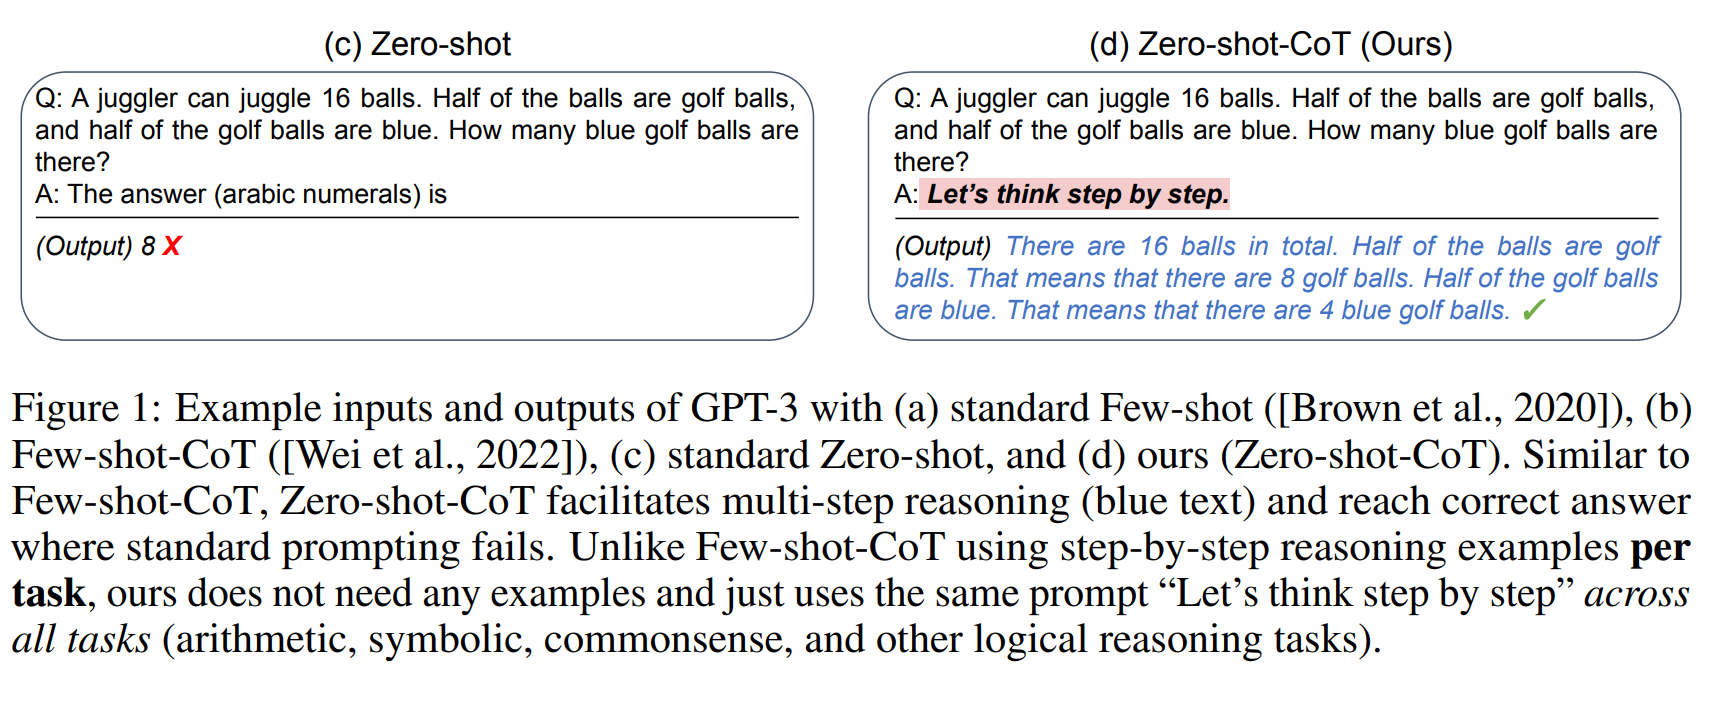

In [ ]:
from liquid import Template

system_prompt = '''You are a helpful math expert, and your task is to answer a math question. Please first think step-by-step and then provide a result (numerical answer). The result must be an integer in the end of your answer.'''  # @param {type: "string"}

system_template = Template('''
Here is the question:
{{question}}

Please think step-by-step.
''')

Let's ask the LLM to answer some questions again (using the updated system prompt) and observe the answers:


In [ ]:
import re
from tqdm import tqdm

answers = []
for context in tqdm(contexts[0:NUM_TEST_EXAMPLES]):
    prompt_final = generate_prompt(context)

    ans = answer(prompt_final)
    answers.append(re.sub("\s+", " ", ans))

print("\n".join(answers))

100%|██████████| 10/10 [03:38<00:00, 21.82s/it]

<|begin_of_text|><|start_header_id|>system<|end_header_id|> Cutting Knowledge Date: December 2023 Today Date: 26 Jul 2024 You are a helpful math expert, and your task is to answer a math question. Please first think step-by-step and then provide a result (numerical answer). The result must be an integer in the end of your answer.<|eot_id|><|start_header_id|>user<|end_header_id|> Here is the question: Janet’s ducks lay 16 eggs per day. She eats three for breakfast every morning and bakes muffins for her friends every day with four. She sells the remainder at the farmers' market daily for $2 per fresh duck egg. How much in dollars does she make every day at the farmers' market? Please think step-by-step.<|eot_id|><|start_header_id|>assistant<|end_header_id|> To find out how much Janet makes every day at the farmers' market, we need to determine the number of eggs she has left after eating and baking, and then multiply that number by the selling price. Step 1: Calculate the number of eggs

Evaluate the model by computing accuracy:

In [ ]:
llama_accuracy = evaluate_accuracy(contexts[0:NUM_TEST_EXAMPLES], answers)
print("LlaMA 3.1 0-shot performance with CoT (in terms of accuracy):", llama_accuracy)

LlaMA 3.2 0-shot performance (in terms of accuracy): 0.5


**Pause and reflect:** Wow! The performance massively improved! 😲 But can we do even better?

* Observe the generated chains-of-thought. Do you spot any particular prolems you should let the system know about? Try to enter different input texts in the `system_prompt` field and see what it gets to produce. Don't forget to encourage it to "think step-by-step", it seems to be a great deal after all. 😉

* Try adding some training examples to help the LLM reason correctly, as we do in the proposed prompt below. This is called few-shot inference, see how it's done below.

## Few-shot inference

We now want to add **few-shot examples (demonstrators)** to help the LLM answer correctly (e.g., see [here](https://arxiv.org/pdf/2201.11903)). Given the question of a test example, we will also add some examples for the LLM to understand the user's expected behavior when producing an output, which we will add as demonstrators (i.e., examples for the LLM to follow) in the prompt.

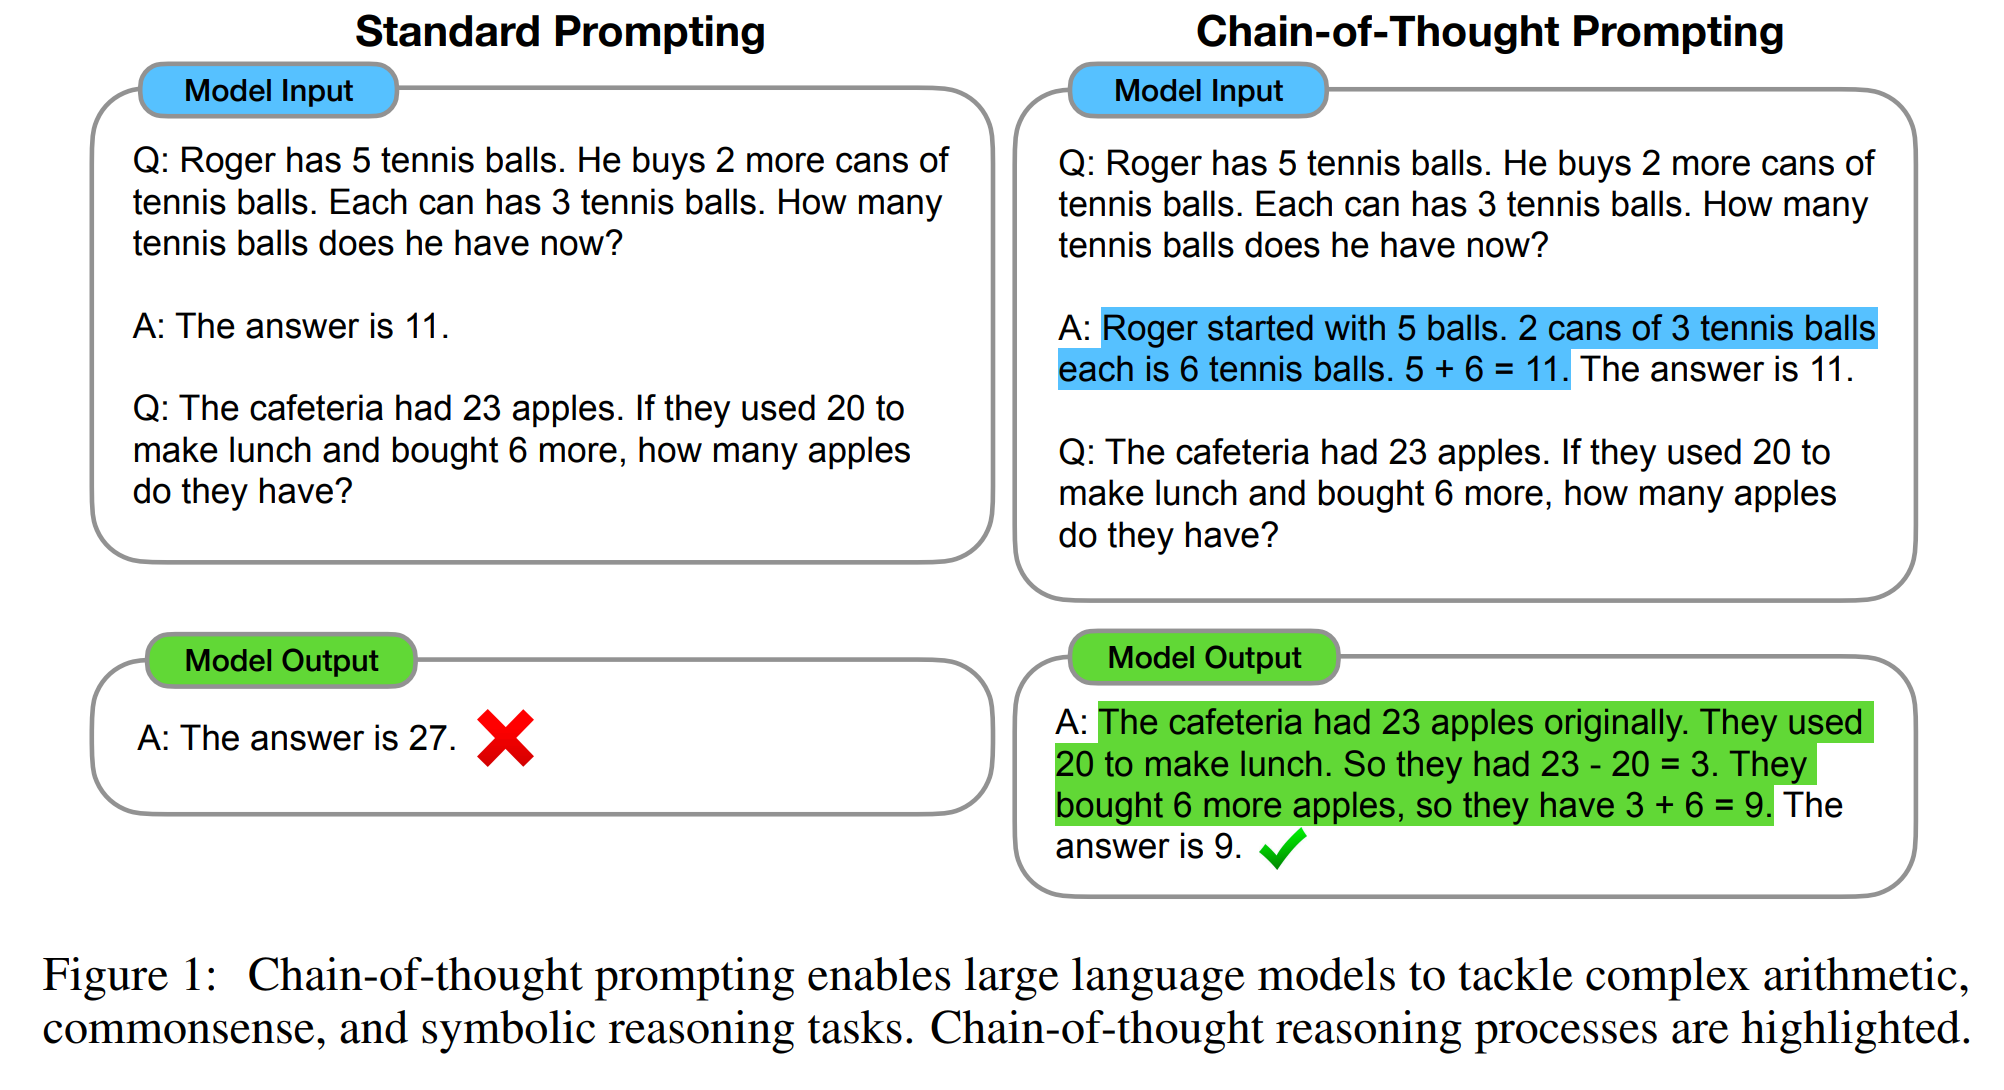

Let's ask the LLM to answer some questions and observe the answers:

In [ ]:
system_prompt_fs = '''You are a helpful math expert, and your task is to answer a math question. Examples of question-answer pairs are provided below, formatted exactly as it is required, followed by a question for you to answer. Please provide a result (numerical answer). The result must be an integer.'''  # @param {type: "string"}

system_template = Template('''
Here is the question:
{{question}}
''')

NUM_DEMONSTRATORS = 2  # @param {type: "string"}
NUM_DEMONSTRATORS = int(NUM_DEMONSTRATORS)

In [ ]:
train_contexts = [[math_data['train']['question'][i], math_data['train']['answer'][i]]
            for i in range(len(math_data['train']['question']))]

In [ ]:
answers = []
for context in tqdm(contexts[0:NUM_TEST_EXAMPLES]):
    messages = [{"role": "system", "content": system_prompt}]

    # Add the examples' questions in the LLM prompt
    for demonstrator in train_contexts[0:NUM_DEMONSTRATORS]:
      prompt_llm = system_template.render(question=demonstrator[0])
      messages.append({"role": "user", "content": prompt_llm})

      # Add the examples' answers in the LLM prompt
      cot_and_answer = demonstrator[1].split("\n####")
      cot_and_answer = "The answer is " + cot_and_answer[1] + "."
      messages.append({"role": "system", "content": cot_and_answer})

    # Add the original question in the LLM prompt
    prompt_llm = system_template.render(question=context[0])
    messages.append({"role": "user", "content": prompt_llm})

    # Ask away!
    prompt_final = tokenizer.apply_chat_template(messages, tokenize=False,
                                                 add_generation_prompt=True)
    ans = answer(prompt_final)
    answers.append(re.sub("\s+", " ", ans))

print("\n".join(answers))

100%|██████████| 10/10 [01:50<00:00, 11.07s/it]

<|begin_of_text|><|start_header_id|>system<|end_header_id|> Cutting Knowledge Date: December 2023 Today Date: 26 Jul 2024 You are a helpful math expert, and your task is to answer a math question. Please first think step-by-step and then provide a result (numerical answer). The result must be an integer in the end of your answer.<|eot_id|><|start_header_id|>user<|end_header_id|> Here is the question: Natalia sold clips to 48 of her friends in April, and then she sold half as many clips in May. How many clips did Natalia sell altogether in April and May?<|eot_id|><|start_header_id|>system<|end_header_id|> The answer is 72.<|eot_id|><|start_header_id|>user<|end_header_id|> Here is the question: Weng earns $12 an hour for babysitting. Yesterday, she just did 50 minutes of babysitting. How much did she earn?<|eot_id|><|start_header_id|>system<|end_header_id|> The answer is 10.<|eot_id|><|start_header_id|>user<|end_header_id|> Here is the question: Janet’s ducks lay 16 eggs per day. She eat

Evaluate the model by computing accuracy:

In [ ]:
llama_accuracy = evaluate_accuracy(contexts[0:NUM_TEST_EXAMPLES], answers)
print("LlaMA 3.1 few-shot performance (in terms of accuracy):", llama_accuracy)

LlaMA 3.1 few-shot performance (in terms of accuracy): 0.7999999999999999


**Pause and reflect:** Wow, the systen got even better! That's a great deal of work you did, you should really be proud of yourselves! 🎊

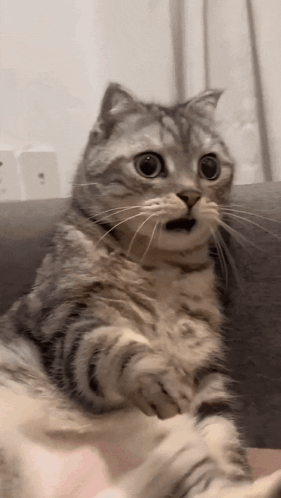

Now you have mastered prompt engineering, can you do even better?

* In the example above, we randomly picked the first 2 examples as few-shot demonstrators, which already ramped up the performance. However, there might be more suitable examples to use. Try to modify the for loop over training examples above to select different few-shot examples, what do you observe?

* *Optional:* Try to pick demonstrators in a more clever way, not randomly, to find the optimal examples for each of the test questions. What would be a good strategy to do that? Feel free to discuss with your peers around, collaborate guys! As we all know, teamwork makes the dreamwork anyway. 🤝

* Encourage chain-of-thought thinking.

## Few-shot inference in harder examples (involving BIG numbers)

**Problem solved? Haha, you wish!** We tested the model in ten randomly selected examples from the test set, the first 10 ones in particular. What happens if we change them and use examples involving BIG numbers in the required arithmetic operations? Will your prompts still work or fail miserably? Can you also unlock this challenge? 🤔

Let's start by loading the new test set.

In [ ]:
def k_largest_indices_np(arr, k=10):
    return np.argsort(arr)[-k:][::-1]

import re
import numpy as np
correct_results = np.array([int(re.sub(",", "", contexts[i][1].split("\n####")[-1].strip())) for i in range(len(contexts))])
pos_largest_results = k_largest_indices_np(correct_results)

print(pos_largest_results)
print([int(correct_results[lrg_id]) for lrg_id in pos_largest_results])

new_test_set = [contexts[lrg_id] for lrg_id in pos_largest_results]

[796 611 715 657 230 641 373 325 343 409]
[2880000, 1450000, 385000, 330000, 276000, 262500, 240000, 224000, 180000, 168000]


We opted for the 10 examples with the larger numbers in their results. Let's try out our best model and see what it gets.

In [ ]:
system_prompt_fs = '''You are a helpful math expert, and your task is to answer a math question. Examples of question-answer pairs are provided below, formatted exactly as it is required, followed by a question for you to answer. Please provide a result (numerical answer). The result must be an integer.'''  # @param {type: "string"}

system_template = Template('''
Here is the question:
{{question}}
''')

NUM_DEMONSTRATORS = 2  # @param {type: "string"}
NUM_DEMONSTRATORS = int(NUM_DEMONSTRATORS)

In [ ]:
answers = []
for context in tqdm(new_test_set):
    messages = [{"role": "system", "content": system_prompt}]

    # Add the examples' questions in the LLM prompt
    for demonstrator in train_contexts[0:NUM_DEMONSTRATORS]:
      prompt_llm = system_template.render(question=demonstrator[0])
      messages.append({"role": "user", "content": prompt_llm})

      # Add the examples' answers in the LLM prompt
      cot_and_answer = demonstrator[1].split("\n####")
      cot_and_answer = "The answer is " + cot_and_answer[1] + "."
      messages.append({"role": "system", "content": cot_and_answer})

    # Add the original question in the LLM prompt
    prompt_llm = system_template.render(question=context[0])
    messages.append({"role": "user", "content": prompt_llm})

    # Ask away!
    prompt_final = tokenizer.apply_chat_template(messages, tokenize=False,
                                                 add_generation_prompt=True)
    ans = answer(prompt_final)
    answers.append(re.sub("\s+", " ", ans))

print("\n".join(answers))

100%|██████████| 10/10 [02:49<00:00, 16.99s/it]

<|begin_of_text|><|start_header_id|>system<|end_header_id|> Cutting Knowledge Date: December 2023 Today Date: 26 Jul 2024 You are a helpful math expert, and your task is to answer a math question. Please first think step-by-step and then provide a result (numerical answer). The result must be an integer in the end of your answer.<|eot_id|><|start_header_id|>user<|end_header_id|> Here is the question: Natalia sold clips to 48 of her friends in April, and then she sold half as many clips in May. How many clips did Natalia sell altogether in April and May?<|eot_id|><|start_header_id|>system<|end_header_id|> The answer is 72.<|eot_id|><|start_header_id|>user<|end_header_id|> Here is the question: Weng earns $12 an hour for babysitting. Yesterday, she just did 50 minutes of babysitting. How much did she earn?<|eot_id|><|start_header_id|>system<|end_header_id|> The answer is 10.<|eot_id|><|start_header_id|>user<|end_header_id|> Here is the question: A company's HR hires 20 new employees ever

In [ ]:
for sample in new_test_set:
  sample[1] = sample[1].split("\n####")
  sample[1][1] = re.sub(",", "", sample[1][1])
  sample[1] = "\n####".join(sample[1])

llama_accuracy = evaluate_accuracy(new_test_set, answers)
print("LlaMA 3.1 few-shot performance with BIG numbers (in terms of accuracy):", llama_accuracy)

LlaMA 3.1 few-shot performance with BIG numbers (in terms of accuracy): 0.4


**Pause and reflect:** Things are not really impressive here! 😞 What can we do?

* Once again, you can play around with the prompt and amount of few-shot examples to see if you can get improved results. As we've already seen, using a better prompt (e.g. encouraging the model to "think step-by-step" can bring significant advancements). Try to enter different input texts in the `system_prompt` field and see what it gets to produce.

* *Optional:* Try your optimal demonstrators selection strategy, which you have potentially developed above, to see if it gives you any boost in performance when BIG numbers are involved. What would be suitable examples?

Let's try to use demonstrators with big numbers to see if the results improve...

In [ ]:
system_prompt_fs = '''You are a helpful math expert, and your task is to answer a math question. Examples of question-answer pairs are provided below, formatted exactly as it is required, followed by a question for you to answer. Please provide a result (numerical answer). The result must be an integer.'''  # @param {type: "string"}

system_template = Template('''
Here is the question:
{{question}}
''')

NUM_DEMONSTRATORS = 2  # @param {type: "string"}
NUM_DEMONSTRATORS = int(NUM_DEMONSTRATORS)

In [ ]:
train_correct_results = np.array([int(re.sub(",", "", train_contexts[i][1].split("\n####")[-1].strip())) for i in range(len(train_contexts))])
pos_train_largest_results = k_largest_indices_np(train_correct_results, k=NUM_DEMONSTRATORS)

print(pos_train_largest_results)
print([int(train_correct_results[lrg_id]) for lrg_id in pos_train_largest_results])

new_demonstrators = [train_contexts[lrg_id] for lrg_id in pos_train_largest_results]

[402 644]
[192000000, 109200000]


Wow, these are really BIG numbers, like those in our test set. 😲 Let's see what we'll get.

In [ ]:
answers = []
for context in tqdm(new_test_set):
    messages = [{"role": "system", "content": system_prompt}]

    # Add the examples' questions in the LLM prompt
    for demonstrator in new_demonstrators:
      prompt_llm = system_template.render(question=demonstrator[0])
      messages.append({"role": "user", "content": prompt_llm})

      # Add the examples' answers in the LLM prompt
      cot_and_answer = demonstrator[1].split("\n####")
      cot_and_answer = "The answer is " + cot_and_answer[1] + "."
      messages.append({"role": "system", "content": cot_and_answer})

    # Add the original question in the LLM prompt
    prompt_llm = system_template.render(question=context[0])
    messages.append({"role": "user", "content": prompt_llm})

    # Ask away!
    prompt_final = tokenizer.apply_chat_template(messages, tokenize=False,
                                                 add_generation_prompt=True)
    ans = answer(prompt_final)
    answers.append(re.sub("\s+", " ", ans))

print("\n".join(answers))

100%|██████████| 10/10 [02:38<00:00, 15.82s/it]

<|begin_of_text|><|start_header_id|>system<|end_header_id|> Cutting Knowledge Date: December 2023 Today Date: 26 Jul 2024 You are a helpful math expert, and your task is to answer a math question. Please first think step-by-step and then provide a result (numerical answer). The result must be an integer in the end of your answer.<|eot_id|><|start_header_id|>user<|end_header_id|> Here is the question: A new movie gets released and makes $120 million in the box office for its opening weekend. It ends up making 3.5 times that much during its entire run. If the production company gets to keep 60%, how much profit did they make if the movie cost $60 million to produce?<|eot_id|><|start_header_id|>system<|end_header_id|> The answer is 192000000.<|eot_id|><|start_header_id|>user<|end_header_id|> Here is the question: The city’s bus system carries 1,200,000 people each day. How many people does the bus system carry for 13 weeks?<|eot_id|><|start_header_id|>system<|end_header_id|> The answer is

In [ ]:
llama_accuracy = evaluate_accuracy(new_test_set, answers)
print("LlaMA 3.1 few-shot performance with BIG numbers and BIG demonstrators (in terms of accuracy):", llama_accuracy)

LlaMA 3.1 few-shot performance with BIG numbers and BIG demonstrators (in terms of accuracy): 0.5


These prompts are quite exhaustive, right? But hold on, we have one more thing to try before calling it a day!

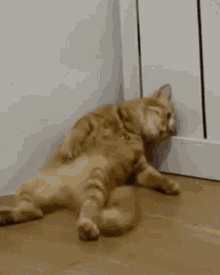

## Few-shot inference using chain-of-thought thinking and structured outputs

Let's increase the output context length so the model can produce longer responses!

In [ ]:
def answer(question, num_beams=1):
    response = gen_pipeline(
        question,
        do_sample=True,
        temperature=0.6,
        num_beams=num_beams,
        max_new_tokens = 5000,
        eos_token_id=[tokenizer.eos_token_id, tokenizer.convert_tokens_to_ids("<|eot_id|>")],
        pad_token_id=tokenizer.eos_token_id,
        truncation=True,
        stopping_criteria=None
    )

    return response[0]['generated_text']

### Using more detailed instructions

Let's now try to use more detailed instructions. Models with more parameters —say, those with tens or hundreds of billions— tend to **follow instructions better and use of Few-Shot or In-Context Learning more effectively**. We will now ask the LLM to format the output as a JSON file with certain keys ("step_by_step_thinking" and "numerical_answer") and values (explanation and answer respectively); something a smaller model would most probably be unable to do (you can try out!)...

In [ ]:
system_prompt_fs = '''You are a helpful math expert, and your task is to answer a math question. Examples of question-answer pairs are provided below, formatted exactly as it is required, followed by a question for you to answer. Please first think step-by-step and then provide a result (numerical answer). Organize your output in a json formatted as Dict{"step_by_step_thinking": Str(explanation), "numerical_answer": Integer}. Use the exact keys mentioned ("step_by_step_thinking" and "numerical_answer") in the dictionary.'''  # @param {type: "string"}

system_template = Template('''
Here is the question:
{{question}}

Please think step-by-step.
''')

In [ ]:
answers = []
for context in tqdm(contexts[0:NUM_TEST_EXAMPLES]):
    messages = [{"role": "system", "content": system_prompt_fs}]

    # Add the examples' questions in the LLM prompt
    for demonstrator in train_contexts[0:NUM_DEMONSTRATORS]:
      prompt_llm = system_template.render(question=demonstrator[0])
      messages.append({"role": "user", "content": prompt_llm})

      # Add the examples' answers in the LLM prompt
      cot_and_answer = demonstrator[1].split("\n####")
      cot_and_answer =  "{\"step_by_step_thinking\": \"" + cot_and_answer[0] + "\", \"numerical_answer:\"" + cot_and_answer[1] + "\"}"
      messages.append({"role": "system", "content": cot_and_answer})

    # Add the original question in the LLM prompt
    prompt_llm = system_template.render(question=context[0])
    messages.append({"role": "user", "content": prompt_llm})

    # Ask away!
    prompt_final = tokenizer.apply_chat_template(messages, tokenize=False,
                                                 add_generation_prompt=True)
    ans = answer(prompt_final)
    answers.append(re.sub("\s+", " ", ans))


print("\n".join(answers))

100%|██████████| 10/10 [01:37<00:00,  9.72s/it]

<|begin_of_text|><|start_header_id|>system<|end_header_id|> Cutting Knowledge Date: December 2023 Today Date: 26 Jul 2024 You are a helpful math expert, and your task is to answer a math question. Examples of question-answer pairs are provided below, formatted exactly as it is required, followed by a question for you to answer. Please first think step-by-step and then provide a result (numerical answer). Organize your output in a json formatted as Dict{"step_by_step_thinking": Str(explanation), "numerical_answer": Integer}. Use the exact keys mentioned ("step_by_step_thinking" and "numerical_answer") in the dictionary.<|eot_id|><|start_header_id|>user<|end_header_id|> Here is the question: Natalia sold clips to 48 of her friends in April, and then she sold half as many clips in May. How many clips did Natalia sell altogether in April and May? Please think step-by-step.<|eot_id|><|start_header_id|>system<|end_header_id|> {"step_by_step_thinking": "Natalia sold 48/2 = <<48/2=24>>24 clips

Since we chave changed the answer layout, we also need a new evaluation function, which will make use of the structured dictionary output (dictionary, in JSON format, with predefined keys) produced by the LLM.

In [ ]:
import re
def check_int(s):
    if s[0] in ('-', '+'):
        return s[1:].isdigit()
    return s.isdigit()

def get_answer(s):
    # Find the answer
    answer = re.sub(r'\D', "", s.split("numerical_answer")[-1].strip())

    if check_int(answer):
        # Return the answer (an integer)
        return int(answer)

    # Return None if no integer is found
    return None

def evaluate_accuracy_new(data, llm_answers):
  accuracy = 0.0
  for i in range(len(data)):
    correct_answer = int(data[i][1].split("\n####")[1].strip())
    llm_answer = get_answer(llm_answers[i])
    if correct_answer == llm_answer:
      accuracy += 1/len(data)
  return accuracy

llama_accuracy = evaluate_accuracy_new(contexts[0:NUM_TEST_EXAMPLES], answers)
print("LlaMA 3.1 0-shot performance (in terms of accuracy):", llama_accuracy)

LlaMA 3.1 0-shot performance (in terms of accuracy): 0.6


### Using more detailed instructions for harder problems (with BIG numbers)

Last but not least, before we go home, let's try to use structured outputs for the hard problem (involving big numbers in the calculations) to see if we'll get any better in terms of accuracy there...

In [ ]:
answers = []
for context in tqdm(new_test_set):
    messages = [{"role": "system", "content": system_prompt}]

    # Add the examples' questions in the LLM prompt
    for demonstrator in new_demonstrators:
      prompt_llm = system_template.render(question=demonstrator[0])
      messages.append({"role": "user", "content": prompt_llm})

      # Add the examples' answers in the LLM prompt
      cot_and_answer = demonstrator[1].split("\n####")
      cot_and_answer = "The answer is " + cot_and_answer[1] + "."
      messages.append({"role": "system", "content": cot_and_answer})

    # Add the original question in the LLM prompt
    prompt_llm = system_template.render(question=context[0])
    messages.append({"role": "user", "content": prompt_llm})

    # Ask away!
    prompt_final = tokenizer.apply_chat_template(messages, tokenize=False,
                                                 add_generation_prompt=True)
    ans = answer(prompt_final)
    answers.append(re.sub("\s+", " ", ans))

print("\n".join(answers))

100%|██████████| 10/10 [02:57<00:00, 17.78s/it]

<|begin_of_text|><|start_header_id|>system<|end_header_id|> Cutting Knowledge Date: December 2023 Today Date: 26 Jul 2024 You are a helpful math expert, and your task is to answer a math question. Please first think step-by-step and then provide a result (numerical answer). The result must be an integer in the end of your answer.<|eot_id|><|start_header_id|>user<|end_header_id|> Here is the question: A new movie gets released and makes $120 million in the box office for its opening weekend. It ends up making 3.5 times that much during its entire run. If the production company gets to keep 60%, how much profit did they make if the movie cost $60 million to produce? Please think step-by-step.<|eot_id|><|start_header_id|>system<|end_header_id|> The answer is 192000000.<|eot_id|><|start_header_id|>user<|end_header_id|> Here is the question: The city’s bus system carries 1,200,000 people each day. How many people does the bus system carry for 13 weeks? Please think step-by-step.<|eot_id|><|

In [ ]:
llama_accuracy = evaluate_accuracy(new_test_set, answers)
print("LlaMA 3.1 few-shot performance with BIG numbers and BIG demonstrators (in terms of accuracy):", llama_accuracy)

LlaMA 3.1 few-shot performance with BIG numbers and BIG demonstrators (in terms of accuracy): 0.30000000000000004
